In [1]:
# Aquest codi funciona amb Python en l'entorn de JupyterLab
# El dividim en apartats per a poder organitzar-nos millor les tasques de l'equip

In [2]:
# 1. IMPORTACIÓ DE LLIBRERIES

# Model de Predicció d'Enfrontaments - La Liga 2023-2024
print("🚀 Iniciant Model de Predicció d'Enfrontaments...")
print("=" * 60)

# Importació de llibreries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Importem molts models per a anar provant que tal van
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('default')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)

print("✅ Llibreries importades correctament")

🚀 Iniciant Model de Predicció d'Enfrontaments...
✅ Llibreries importades correctament


In [3]:
# 2. IMPORTACIÓ I LECTURA DE DADES

print("Carregant dades...")

# Carregament de dades
# Si fem servir la Base De Dades (d'ara endevant BDD) fusionada excloem la columna temporada que dona problemes
df_classificacio = pd.read_excel('BDD_EntrenamentModel_Estadístiques-La_Liga-FUSIONADA.xlsx', 
                                sheet_name='ClassificacióGeneral').drop('Temporada', axis=1, errors='ignore')

df_partits = pd.read_excel('BDD_EntrenamentModel_Estadístiques-La_Liga-FUSIONADA.xlsx', 
                           sheet_name='StatsPartit').drop('Temporada', axis=1, errors='ignore')

df_jornades_25_26 = pd.read_excel('Jornades_LaLiga_25-26.xlsx')

print(f"Dades de classificació: {df_classificacio.shape}")
print(f"Dades de partits: {df_partits.shape}")
print(f"Nombre d'equips BDD FUSIONADA: {len(df_classificacio['Team'].unique())}")
print(f"Nombre d'equips LaLiga 2025-26: {len(df_jornades_25_26['Home_Team'].unique())}")
# Aqui dona el doble de partits perquè per cada partit tenim dues estadistiques, del visitant i el local
print(f"Partits analitzats: {len(df_partits)}")


print("Equips temporada 2025-2026:")
for equip in df_jornades_25_26['Home_Team'].unique():
    print(equip)
print('Dades llegides correctament')

Carregant dades...
Dades de classificació: (26, 27)
Dades de partits: (1540, 39)
Nombre d'equips BDD FUSIONADA: 26
Nombre d'equips LaLiga 2025-26: 20
Partits analitzats: 1540
Equips temporada 2025-2026:
Alavés
Athletic Club
Celta Vigo
Girona
Espanyol
Mallorca
Elche CF
Real Madrid
Valencia
Villarreal
Sevilla
Real Sociedad
Levante 
Osasuna
Real Oviedo
Atlético Madrid
Real Betis
Rayo Vallecano
Getafe
Barcelona
Dades llegides correctament


In [4]:
# 3. FILTRATGE I TRANSFORMACIÓ DE DADES

# Aquí fusionem les dades de classificacio i partits per crear un dataframe més complet amb les estadístiques de cada equip
# És perfecte per a poder predir partits individuals i correlacions

print("PREPARACIÓ DE DADES")
print("=" * 50)

# Funció per obtenir estadístiques d'un equip
def obtenir_stats_equip(equip_nom, df_classificacio):
    """Obtenim les estadístiques d'un equip específic"""
    if equip_nom in df_classificacio['Team'].values:
        return df_classificacio[df_classificacio['Team'] == equip_nom].iloc[0]
    else:
        # Si no trobem l'equip, retornem valors mitjans
        return df_classificacio.mean(numeric_only=True)

# Funció per crear features dels equips
def crear_features_equips(df_partits, df_classificacio):
    """Creem features combinant estadístiques dels equips amb dades de partits"""
    df_nou = df_partits.copy()
    
    # Columnes de classificació (excloent 'Team')
    stats_columns = [col for col in df_classificacio.columns if col != 'Team']
    
    # Afegim estadístiques de l'equip local
    for col in stats_columns:
        df_nou[f'Home_{col}'] = df_nou['Home Team'].map(
            df_classificacio.set_index('Team')[col]
        ).fillna(df_classificacio[col].mean())
    
    # Afegim estadístiques de l'equip visitant
    for col in stats_columns:
        df_nou[f'Away_{col}'] = df_nou['Away Team'].map(
            df_classificacio.set_index('Team')[col]
        ).fillna(df_classificacio[col].mean())

    # NOVES FEATURES AVANÇADES (derivades de les principals)
    # Recomanades per ChatGPT i Deepseek
    
    # 1. Diferències de formació entre equips
    df_nou['Form_Difference'] = df_nou['Home_%_Victories'] - df_nou['Away_%_Victories']
    df_nou['Goals_Difference'] = df_nou['Home_GF'] - df_nou['Away_GF']
    df_nou['Defense_Difference'] = df_nou['Away_GA'] - df_nou['Home_GA']
    
    # 2. Ràtios de rendiment en atac
    df_nou['Home_Attack_Ratio'] = df_nou['Home_GF'] / (df_nou['Home_GF'] + df_nou['Home_GA']).replace(0, 1)
    df_nou['Away_Attack_Ratio'] = df_nou['Away_GF'] / (df_nou['Away_GF'] + df_nou['Away_GA']).replace(0, 1)
    
    # 3. Momentum (últimes victòries)
    df_nou['Home_Momentum'] = df_nou['Home_%_Victories'] * df_nou['Home_GF']
    df_nou['Away_Momentum'] = df_nou['Away_%_Victories'] * df_nou['Away_GF']
    
    # 5. Pressió ofensiva
    df_nou['Home_Attack_Pressure'] = df_nou['Home_GF'] * df_nou['Home_%_Victories']
    df_nou['Away_Attack_Pressure'] = df_nou['Away_GF'] * df_nou['Away_%_Victories']
    
    return df_nou

print("Preparant dades...")

# Apliquem la funció
df_complet = crear_features_equips(df_partits, df_classificacio)

print(f"✅ Dataset complet creat: {df_complet.shape}")
print(f"📊 Features dels equips: {len([col for col in df_complet.columns if col.startswith('Home_') or col.startswith('Away_')])}")

# Creació de variables objectiu
print("\n🎯 Creant variables objectiu...")

# Variables objectiu
df_complet['Victory'] = (df_complet['Home Goal'] > df_complet['Away Goal']).astype(int)
df_complet['Draw'] = (df_complet['Home Goal'] == df_complet['Away Goal']).astype(int)
df_complet['Total_Goals'] = df_complet['Home Goal'] + df_complet['Away Goal']
df_complet['Goal_Difference'] = df_complet['Home Goal'] - df_complet['Away Goal']

# Resultat categòric
def crear_resultat_categoric(row):
    if row['Home Goal'] > row['Away Goal']:
        return 'Home_Win'
    elif row['Home Goal'] < row['Away Goal']:
        return 'Away_Win'
    else:
        return 'Draw'

df_complet['Result'] = df_complet.apply(crear_resultat_categoric, axis=1)

# Mostrem estadístiques
print("\n📈 Estadístiques de les variables objectiu:")
print(f"- Victòries locals: {df_complet['Victory'].sum()} ({df_complet['Victory'].mean():.1%})")
print(f"- Empats: {df_complet['Draw'].sum()} ({df_complet['Draw'].mean():.1%})")
print(f"- Gols totals (mitjana): {df_complet['Total_Goals'].mean():.2f}")
print(f"- Corners (mitjana): {df_complet['wonCorners'].mean():.1f}")

print("\n🏆 Distribució de resultats:")
for resultat, count in df_complet['Result'].value_counts().items():
    print(f"  {resultat}: {count} ({count/len(df_complet):.1%})")

# Selecció de features per al model
print("\n🔍 Seleccionant features...")

# Features del partit
features_partit_cols = [
    'foulsCommitted', 'yellowCards', 'redCards', 'offsides', 'wonCorners',
    'saves', 'possessionPct', 'totalShots', 'shotsOnTarget', 'shotPct',
    'penaltyKickGoals', 'penaltyKickShots', 'accuratePasses', 'totalPasses',
    'passPct', 'accurateCrosses', 'totalCrosses', 'crossPct', 'accurateLongBalls',
    'totalLongBalls', 'longballPct', 'blockedShots', 'effectiveTackles',
    'totalTackles', 'tacklePct', 'interceptions', 'effectiveClearance', 'totalClearance'
]

# Features dels equips
features_equips = [col for col in df_complet.columns if col.startswith('Home_') or col.startswith('Away_')]

# Combinem totes les features
X_features = features_partit_cols + features_equips

# Dataset final per al model
df_model = df_complet[X_features + ['Victory', 'Total_Goals', 'wonCorners', 'Result','homeAway']].dropna()
# Esborrem WonCorners que la teniem duplicada i donava molts problemes
df_model = df_model.loc[:, ~df_model.columns.duplicated()]


X = df_model[X_features]
y_victory = df_model['Victory']
y_goals = df_model['Total_Goals']
y_corners = df_model['wonCorners']
y_result = df_model['Result']

# Normalitzem les dades per a que variables amb valors alts no es mengin a les petites
scaler = StandardScaler()
X = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index)

print(f"✅ Dataset final: {df_model.shape}")
print(f"📊 Features utilitzades: {len(X_features)}")
print(f"�� Variables objectiu: Victòria, Gols Totals, Corners, Resultat")

PREPARACIÓ DE DADES
Preparant dades...
✅ Dataset complet creat: (1540, 100)
📊 Features dels equips: 58

🎯 Creant variables objectiu...

📈 Estadístiques de les variables objectiu:
- Victòries locals: 682 (44.3%)
- Empats: 412 (26.8%)
- Gols totals (mitjana): 2.63
- Corners (mitjana): 4.7

🏆 Distribució de resultats:
  Home_Win: 682 (44.3%)
  Away_Win: 446 (29.0%)
  Draw: 412 (26.8%)

🔍 Seleccionant features...
✅ Dataset final: (1540, 90)
📊 Features utilitzades: 86
�� Variables objectiu: Victòria, Gols Totals, Corners, Resultat


ANÀLISI DE VARIABLES I CORRELACIONS

Top 15 correlacions amb Victory:
1. Home_Attack_Ratio: 0.354
2. Home_Momentum: 0.345
3. Home_Attack_Pressure: 0.345
4. Home_Home GF: 0.334
5. Home_M_HomeGF: 0.332
6. Home_GF: 0.327
7. Home_M_GolsF: 0.326
8. Away_Attack_Ratio: -0.326
9. Home_Clean Sheets: 0.318
10. Away_GF: -0.313
11. Home_%_CS: 0.313
12. Away_Home GF: -0.309
13. Away_Attack_Pressure: -0.301
14. Away_Momentum: -0.301
15. Away_Clean Sheets: -0.297


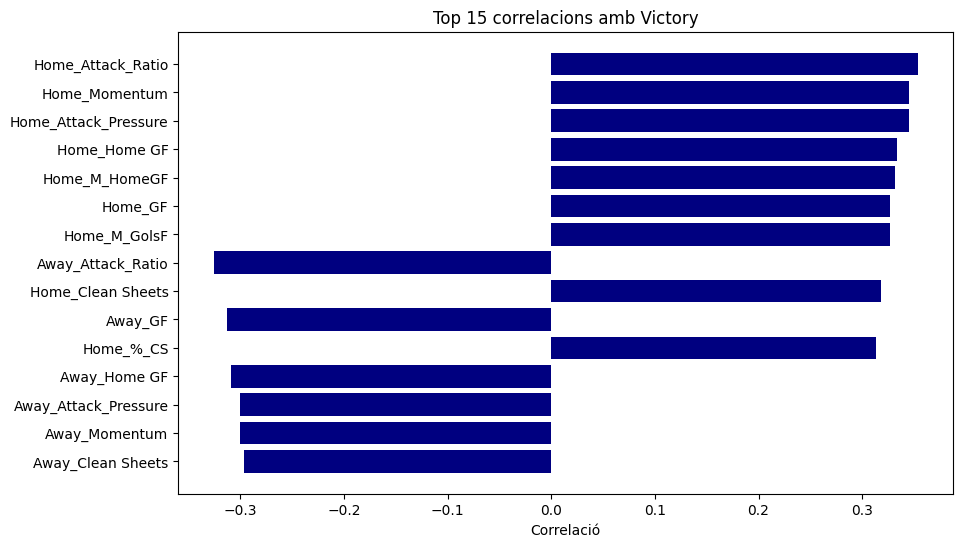


Top 15 correlacions amb Total_Goals:
1. shotsOnTarget: 0.397
2. Home_M_HomeGF: 0.272
3. Home_M_GolsF: 0.262
4. Home_Home GF: 0.240
5. Home_GF: 0.226
6. Home_Attack_Pressure: 0.225
7. Home_Momentum: 0.225
8. penaltyKickGoals: 0.207
9. Home_Attack_Ratio: 0.195
10. penaltyKickShots: 0.186
11. totalLongBalls: -0.162
12. totalShots: 0.159
13. Away_M_GolsC: 0.144
14. totalClearance: -0.134
15. effectiveClearance: -0.134


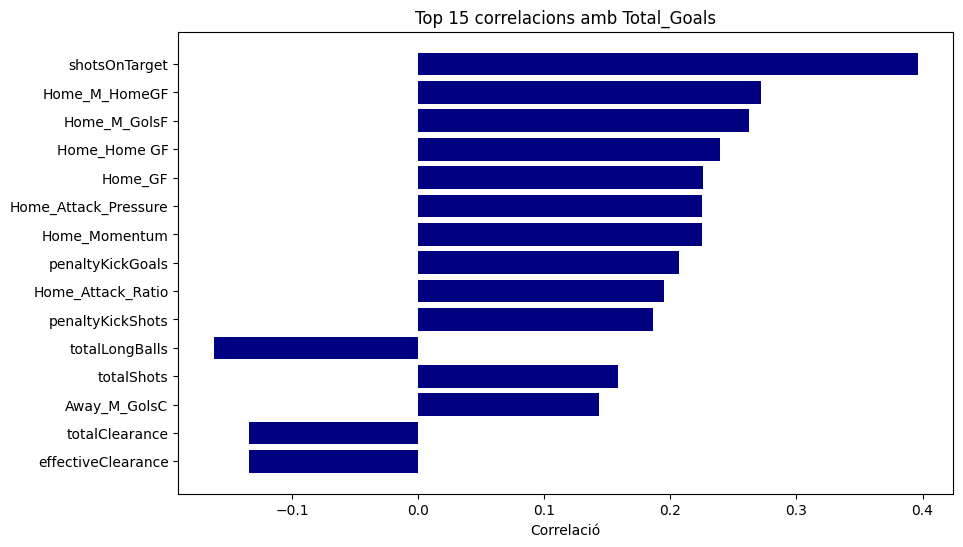

⚠️ La columna Goal_Difference no existeix!


In [5]:
# 4. ANÀLISI DE VARIABLES I CORRELACIONS

print("ANÀLISI DE VARIABLES I CORRELACIONS")
print("=" * 50)

targets = ['Victory', 'Total_Goals', 'Goal_Difference']

# Codifiquem homeAway: 1 si juga a casa, 0 si juga fora
df_model['isHome'] = df_model['homeAway'].map({'home': 1, 'away': 0})

# Variables a excloure (derivades de resultats)
excloure_vars = [
    'Home_Victory', 'Home_%_Victories', 'Home_Empats', 'Home_%_Empats',
    'Home_Derrotes', 'Home_%_Derrotes', 'Home_GD', 'Home_Home Win',
    'Home_%_HomeWin', 'Home_Home Draw', 'Home_%_HomeDraw', 'Home_Home Loss',
    'Home_%_HomeLoss', 'Away_Victory', 'Away_%_Victories', 'Away_Empats',
    'Away_%_Empats', 'Away_Derrotes', 'Away_%_Derrotes', 'Away_GD',
    'Away_Home Win', 'Away_%_HomeWin', 'Away_Home Draw', 'Away_%_HomeDraw',
    'Away_Home Loss', 'Away_%_HomeLoss'
]

# Columnes numèriques de df_model
numeric_cols = df_model.select_dtypes(include='number').columns.tolist()

# Filtrar excloent variables derivades de resultat
features_cols = [col for col in numeric_cols if col not in excloure_vars + targets]

for target in targets:
    if target not in df_model.columns:
        print(f"⚠️ La columna {target} no existeix!")
        continue

    print(f"\nTop 15 correlacions amb {target}:")
    corr = df_model[features_cols + [target]].corr()[target].drop(target, errors='ignore')
    corr_abs_sorted = corr.abs().sort_values(ascending=False)
    top15 = corr_abs_sorted.head(15).index.tolist()

    for i, col in enumerate(top15, 1):
        print(f"{i}. {col}: {corr[col]:.3f}")

    plt.figure(figsize=(10, 6))
    values = corr[top15]
    plt.barh(range(len(values)), values.values, color='navy')
    plt.yticks(range(len(values)), top15)
    plt.xlabel('Correlació')
    plt.title(f'Top 15 correlacions amb {target}')
    plt.gca().invert_yaxis()
    plt.show()


In [6]:
# 5. ENTRENAMENT I FORMACIÓ DELS MODELS PREDICTIUS

# !!! ELS MODELS VAN FATAL DE MOMENT EXCEPTE EL DE VICTÒRIA
# HEM DE TREURE VARIABLES DEL df_model NO RELLEVANTS FIXANT-NOS EN LES CORRELACIONS
# PODEM PROVAR TAMBÉ ALTRES TIPUS DE MODELS COM:
# Gradient Boosting (XGBoost, LightGBM), SVM, xarxes neuronals, o models ensemble.


print("ENTRENAMENT DE MODELS")
print("=" * 50)

# Eliminar duplicats de columnes a X
# El problema que teniem en el següent bloc era que Won_corners estava duplicat.
# Afegint això borrem columnes duplicades i ja no salta error
X = X.loc[:, ~X.columns.duplicated()]

# Assignar noms de features reals
X_features = X.columns.tolist()

# Divisió de dades
print("🔄 Dividint dades en entrenament i test...")

X_train, X_test, y_victory_train, y_victory_test = train_test_split(
    X, y_victory, test_size=0.2, random_state=42, stratify=y_victory
)

_, _, y_goals_train, y_goals_test = train_test_split(
    X, y_goals, test_size=0.2, random_state=42
)

_, _, y_corners_train, y_corners_test = train_test_split(
    X, y_corners, test_size=0.2, random_state=42
)

_, _, y_result_train, y_result_test = train_test_split(
    X, y_result, test_size=0.2, random_state=42, stratify=y_result
)

print(f"📚 Dades d'entrenament: {X_train.shape}")
print(f"🧪 Dades de test: {X_test.shape}")

# Entrenament dels models
print("\n🤖 ENTRENAMENT DELS MODELS")
print("=" * 50)


# Model 1: Predicció de victòria
print("\n1️⃣ Model de Predicció de Victòria")
# Deixo el codi del RandomForest anulat per no haver d'anar escrivint sempre que volem canviar
# De moment LogisticRegression i RandomForest donen exactament la mateixa precisió
model_victory = RandomForestClassifier(n_estimators=100, random_state=42)
# model_victory = LogisticRegression(max_iter=5000, random_state=42)
model_victory.fit(X_train, y_victory_train)
victory_pred = model_victory.predict(X_test)
victory_accuracy = accuracy_score(y_victory_test, victory_pred)
print(f"   ✅ Precisió: {victory_accuracy:.3f}")

# Model 2: Predicció de gols totals
print("\n2️⃣ Model de Predicció de Gols Totals")
# Deixo el codi del RandomForest anulat per no haver d'anar escrivint sempre que volem canviar
model_goals = RandomForestRegressor(n_estimators=100, random_state=42)
# model_goals = HistGradientBoostingRegressor(random_state=42)
model_goals.fit(X_train, y_goals_train)
goals_pred = model_goals.predict(X_test)
goals_mse = mean_squared_error(y_goals_test, goals_pred)
print(f"   ✅ RMSE: {np.sqrt(goals_mse):.3f}")

# Model 3: Predicció de corners
print("\n3️⃣ Model de Predicció de Corners")
model_corners = RandomForestRegressor(n_estimators=100, random_state=42)
model_corners.fit(X_train, y_corners_train)
corners_pred = model_corners.predict(X_test)
corners_mse = mean_squared_error(y_corners_test, corners_pred)
print(f"   ✅ RMSE: {np.sqrt(corners_mse):.3f}")

# Model 4: Predicció de resultat complet
print("\n4️⃣ Model de Predicció de Resultat")
model_result = RandomForestClassifier(n_estimators=100, random_state=42)
model_result.fit(X_train, y_result_train)
result_pred = model_result.predict(X_test)
result_accuracy = accuracy_score(y_result_test, result_pred)
print(f"   ✅ Precisió: {result_accuracy:.3f}")

print("\n📊 Report de classificació (Resultat):")
print(classification_report(y_result_test, result_pred))
# En precisió, com més alt millor
# En RMSE com més baix millor: RMSE de 2 vol dir que s'equivoca en dues unitats
# Si s'equivoca de dos gols és molt dolent

ENTRENAMENT DE MODELS
🔄 Dividint dades en entrenament i test...
📚 Dades d'entrenament: (1232, 86)
🧪 Dades de test: (308, 86)

🤖 ENTRENAMENT DELS MODELS

1️⃣ Model de Predicció de Victòria
   ✅ Precisió: 0.763

2️⃣ Model de Predicció de Gols Totals
   ✅ RMSE: 1.826

3️⃣ Model de Predicció de Corners
   ✅ RMSE: 3.123

4️⃣ Model de Predicció de Resultat
   ✅ Precisió: 0.429

📊 Report de classificació (Resultat):
              precision    recall  f1-score   support

    Away_Win       0.35      0.18      0.24        89
        Draw       0.36      0.18      0.24        83
    Home_Win       0.46      0.74      0.57       136

    accuracy                           0.43       308
   macro avg       0.39      0.37      0.35       308
weighted avg       0.40      0.43      0.38       308




🔍 ANÀLISI D'IMPORTÀNCIA DE FEATURES

🏆 Top 10 features per a predicció de victòria:
  28. totalClearance            0.0244
   7. possessionPct             0.0240
  17. totalCrosses              0.0232
  27. effectiveClearance        0.0206
  48. Home_%_HomeWin            0.0202
  14. totalPasses               0.0202
  13. accuratePasses            0.0192
  20. totalLongBalls            0.0191
  44. Home_%_Victories          0.0191
  24. totalTackles              0.0184

⚽ Top 10 features per a predicció de gols:
   7. possessionPct             0.0474
  20. totalLongBalls            0.0416
  14. totalPasses               0.0390
  19. accurateLongBalls         0.0373
   1. foulsCommitted            0.0371
  17. totalCrosses              0.0346
  24. totalTackles              0.0333
  13. accuratePasses            0.0326
  23. effectiveTackles          0.0310
   8. totalShots                0.0306


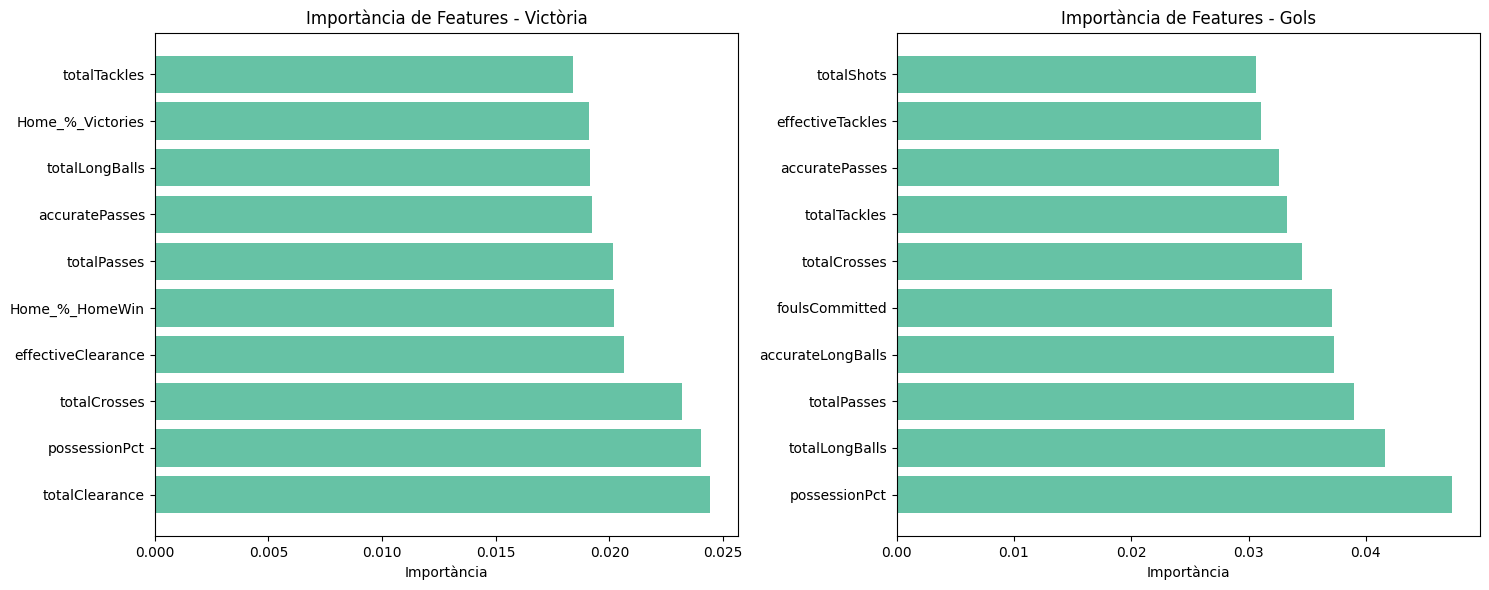


📊 ANÀLISI DE RENDIMENT


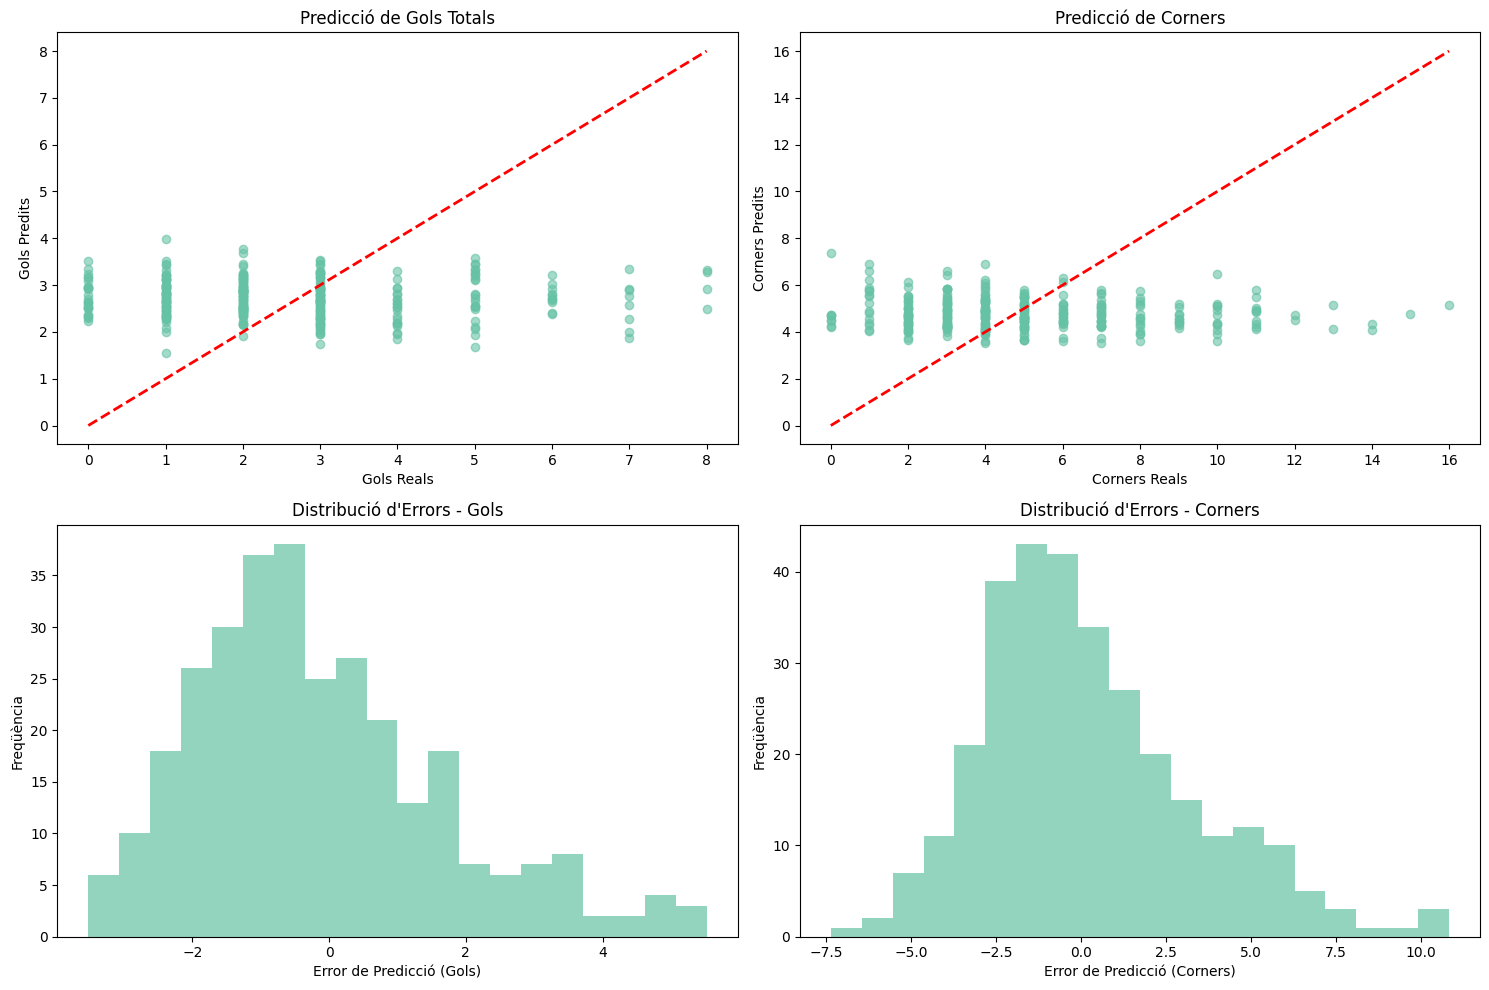


�� Resum de rendiment dels models:
- Precisió victòria: 76.3%
- RMSE gols: 1.83
- RMSE corners: 3.12
- Precisió resultat: 42.9%


In [7]:
# 6. ANÀLISI D'IMPORTÀNCIA DE FEATURES

# Aquest apartat és similar al de les correlacions però ja dins dels models predictius

print("\n🔍 ANÀLISI D'IMPORTÀNCIA DE FEATURES")
print("=" * 50)

# Obtenim importància per a cada model
feature_importance_victory = pd.DataFrame({
    'feature': X_features,
    'importance': model_victory.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_goals = pd.DataFrame({
    'feature': X_features,
    'importance': model_goals.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🏆 Top 10 features per a predicció de victòria:")
for i, row in feature_importance_victory.head(10).iterrows():
    print(f"  {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

print("\n⚽ Top 10 features per a predicció de gols:")
for i, row in feature_importance_goals.head(10).iterrows():
    print(f"  {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

# Visualització de la importància de features
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
top_features_victory = feature_importance_victory.head(10)
plt.barh(range(len(top_features_victory)), top_features_victory['importance'])
plt.yticks(range(len(top_features_victory)), top_features_victory['feature'])
plt.title('Importància de Features - Victòria')
plt.xlabel('Importància')

plt.subplot(1, 2, 2)
top_features_goals = feature_importance_goals.head(10)
plt.barh(range(len(top_features_goals)), top_features_goals['importance'])
plt.yticks(range(len(top_features_goals)), top_features_goals['feature'])
plt.title('Importància de Features - Gols')
plt.xlabel('Importància')

plt.tight_layout()
plt.show()

# Anàlisi de rendiment dels models
print("\n📊 ANÀLISI DE RENDIMENT")
print("=" * 50)

# Comparació de prediccions vs valors reals
plt.figure(figsize=(15, 10))

# Predicció de gols
plt.subplot(2, 2, 1)
plt.scatter(y_goals_test, goals_pred, alpha=0.6)
plt.plot([y_goals_test.min(), y_goals_test.max()], [y_goals_test.min(), y_goals_test.max()], 'r--', lw=2)
plt.xlabel('Gols Reals')
plt.ylabel('Gols Predits')
plt.title('Predicció de Gols Totals')

# Predicció de corners
plt.subplot(2, 2, 2)
plt.scatter(y_corners_test, corners_pred, alpha=0.6)
plt.plot([y_corners_test.min(), y_corners_test.max()], [y_corners_test.min(), y_corners_test.max()], 'r--', lw=2)
plt.xlabel('Corners Reals')
plt.ylabel('Corners Predits')
plt.title('Predicció de Corners')

# Distribució d'errors de gols
plt.subplot(2, 2, 3)
errors_goals = y_goals_test - goals_pred
plt.hist(errors_goals, bins=20, alpha=0.7)
plt.xlabel('Error de Predicció (Gols)')
plt.ylabel('Freqüència')
plt.title('Distribució d\'Errors - Gols')

# Distribució d'errors de corners
plt.subplot(2, 2, 4)
errors_corners = y_corners_test - corners_pred
plt.hist(errors_corners, bins=20, alpha=0.7)
plt.xlabel('Error de Predicció (Corners)')
plt.ylabel('Freqüència')
plt.title('Distribució d\'Errors - Corners')

plt.tight_layout()
plt.show()

# Resum de mètriques
print(f"\n�� Resum de rendiment dels models:")
print(f"- Precisió victòria: {victory_accuracy:.1%}")
print(f"- RMSE gols: {np.sqrt(goals_mse):.2f}")
print(f"- RMSE corners: {np.sqrt(corners_mse):.2f}")
print(f"- Precisió resultat: {result_accuracy:.1%}")

In [8]:
duplicades = df_model.columns[df_model.columns.duplicated()].tolist()
print("Columnes duplicades:", duplicades)

Columnes duplicades: []


In [9]:
# 7. DEFINICIÓ DE LES FUNCIONS PREDICTIVES DELS MODELS

# Funció per fer prediccions
def predir_partit(equip_local, equip_visitant, df_classificacio, df_model, X_features, models):
    """
    Prediu el resultat d'un partit específic
    """
    
    # Obtenim estadístiques dels equips
    stats_local = df_classificacio[df_classificacio['Team'] == equip_local]
    stats_visitant = df_classificacio[df_classificacio['Team'] == equip_visitant]
    
    if stats_local.empty or stats_visitant.empty:
        print(f"⚠️  No s'han trobat les dades per a {equip_local} o {equip_visitant}")
        return None
    
    # Creem vector de features
    features_partit = {}
    
    # Estadístiques dels equips
    for col in df_classificacio.columns:
        if col != 'Team':
            features_partit[f'Home_{col}'] = float(stats_local[col].values[0])
            features_partit[f'Away_{col}'] = float(stats_visitant[col].values[0])

    # Valors mitjans per a estadístiques del partit
    for col in X_features:
        if col not in features_partit:
            features_partit[col] = float(df_model[col].mean())

    # Convertim a DataFrame
    df_prediccio = pd.DataFrame([features_partit])
    X_prediccio = df_prediccio[X_features]
    
    # Normalitzar les dades (mantenint DataFrame perquè sino salta error)
    X_prediccio_scaled = pd.DataFrame(
        scaler.transform(X_prediccio),
        columns=X_prediccio.columns,
        index=X_prediccio.index
    )
    
    # Fem prediccions
    pred_goals = models['goals'].predict(X_prediccio_scaled)[0]
    pred_corners = models['corners'].predict(X_prediccio_scaled)[0]
    
    # Probabilitats del resultat complet (Home_Win, Draw, Away_Win)
    probabilitats_resultat = models['result'].predict_proba(X_prediccio_scaled)[0]
    
    # He passat aquesta funció pel chat perquè el model invertia homewin amb victòria del visitant
    # Verificar l'ordre real de les classes
    classes_reals = models['result'].classes_

    # Assignar probabilitats segons l'ordre real
    if 'Home_Win' in classes_reals and 'Draw' in classes_reals and 'Away_Win' in classes_reals:
        idx_home = list(classes_reals).index('Home_Win')
        idx_draw = list(classes_reals).index('Draw')
        idx_away = list(classes_reals).index('Away_Win')
        
        prob_home_win = probabilitats_resultat[idx_home]
        prob_draw = probabilitats_resultat[idx_draw]
        prob_away_win = probabilitats_resultat[idx_away]
    else:
        # Fallback si les classes no coincideixen
        prob_home_win = probabilitats_resultat[0]
        prob_draw = probabilitats_resultat[1]
        prob_away_win = probabilitats_resultat[2]
    
    if prob_home_win > prob_draw and prob_home_win > prob_away_win:
        resultat_final = 'Home_Win'
    elif prob_away_win > prob_home_win and prob_away_win > prob_draw:
        resultat_final = 'Away_Win'
    elif prob_away_win == prob_home_win and prob_home_win > prob_draw:
        resultat_final = 'Home_Win & Away_Win son igual de probables'
    elif prob_away_win == prob_home_win == prob_draw:
        resultat_final = 'Home_Win & Away_Win & Draw son igual de probables' 
    elif prob_away_win == prob_draw and prob_draw > prob_home_win:
        resultat_final = 'Draw & Away_Win son igual de probables'
    elif prob_home_win == prob_draw and prob_draw > prob_away_win:
        resultat_final = 'Draw & Home_Win son igual de probables'
    else:
        resultat_final = 'Draw'
    
    # DE MOMENT DEIXEM EL MODEL DE PRED VICTÒRIA I FEM SERVIR NOMÉS EL DE RESULTAT
    pred_result = models['result'].predict(X_prediccio_scaled)[0]
    
    return {
        'equip_local': equip_local,
        'equip_visitant': equip_visitant,
        'probabilitat_victoria_local': f"{round(prob_home_win * 100, 1)}%",
        'probabilitat_empat': f"{round(prob_draw * 100, 1)}%",
        'probabilitat_victoria_visitant': f"{round(prob_away_win * 100, 1)}%",
        'gols_totals_previstos': float(round(pred_goals, 1)),
        'corners_previstos': float(round(pred_corners, 1)),
        'resultat_previst': resultat_final
    }

# Diccionari amb els models
models = {
    'victory': model_victory,
    'goals': model_goals,
    'corners': model_corners,
    'result': model_result
}



In [10]:
predir_partit('Getafe', 'Alavés',df_classificacio, df_model, X_features, models)

{'equip_local': 'Getafe',
 'equip_visitant': 'Alavés',
 'probabilitat_victoria_local': '35.0%',
 'probabilitat_empat': '23.0%',
 'probabilitat_victoria_visitant': '42.0%',
 'gols_totals_previstos': 2.3,
 'corners_previstos': 4.4,
 'resultat_previst': 'Away_Win'}

In [11]:
# Afegim la funció de predir jornades en una altra cela per a guardar l'ordre (sino quedava molt llarg)

def predir_jornada_completa(numero_jornada):
    """
    Prediu tots els enfrontaments d'una jornada específica
    
    Args:
        numero_jornada (int): Número de la jornada (1, 2, 3...)
    
    Returns:
        DataFrame amb totes les prediccions de la jornada
    """
    print(f"PREDINT JORNADA {numero_jornada} COMPLETA")
    print("=" * 60)
    
    try:
        # Filtrar per la jornada específica
        jornada_data = df_jornades_25_26[df_jornades_25_26['Jornada'] == numero_jornada].copy()
        
        if len(jornada_data) == 0:
            print(f"No s'ha trobat cap partit per a la jornada {numero_jornada}")
            jornades_disponibles = sorted(df_jornades_25_26['Jornada'].unique())
            print(f"Jornades disponibles: {jornades_disponibles}")
            return None
        
        print(f"Jornada {numero_jornada}: Hi ha {len(jornada_data)} partits")
        print()
        
        # Llista per emmagatzemar totes les prediccions
        prediccions_jornada = []
        
        # Fer predicció per a cada partit de la jornada
        for idx, partit in jornada_data.iterrows():
            home_team = partit['Home_Team']
            away_team = partit['Away_Team']
            
            print(f"⚽ {home_team} vs {away_team}")
            
            # Fer la predicció
            resultat = predir_partit(home_team, away_team, df_classificacio, df_model, X_features, models)
            
            if resultat:
                # Afegir informació del partit
                resultat['Jornada'] = numero_jornada
                resultat['Home_Team'] = home_team
                resultat['Away_Team'] = away_team
                resultat['Partit'] = f"{home_team} vs {away_team}"
                
                prediccions_jornada.append(resultat)
                
                # Mostrar resum de la predicció
                print(f"   Resultat previst: {resultat['resultat_previst']}")
                print(f"   Probabilitats: Local {resultat['probabilitat_victoria_local']}% | "
                      f"Empat {resultat['probabilitat_empat']}% | "
                      f"Visitant {resultat['probabilitat_victoria_visitant']}%")
                print(f"   Gols previstos: {resultat['gols_totals_previstos']}")
                
            else:
                print(f"Error en la predicció")
                
        # Crear DataFrame amb totes les prediccions
        if prediccions_jornada:
            df_prediccions = pd.DataFrame(prediccions_jornada)
            
            # Reorganitzar columnes per a millor visualització
            columnes_ordre = ['Jornada', 'Partit', 'Home_Team', 'Away_Team', 'resultat_previst',
                             'probabilitat_victoria_local', 'probabilitat_empat', 'probabilitat_victoria_visitant',
                             'gols_totals_previstos', 'corners_previstos', 'gols_interval_confiança', 
                             'corners_interval_confiança']
            
            # Filtrar només les columnes que existeixen
            columnes_existents = [col for col in columnes_ordre if col in df_prediccions.columns]
            df_prediccions = df_prediccions[columnes_existents]
            
            print("RESUM DE LA JORNADA:")
            print("=" * 60)
            print(df_prediccions.to_string(index=False))
            
            # Crear visualització amb matplotlib/seaborn
            plt.figure(figsize=(14, 8))
            
            # Crear taula amb les prediccions
            table_data = df_prediccions[['Partit', 'resultat_previst', 'probabilitat_victoria_local', 
                                       'probabilitat_empat', 'probabilitat_victoria_visitant', 'gols_totals_previstos']].copy()
            
            # Renombrar columnes per a millor visualització
            table_data.columns = ['Partit', 'Resultat', 'Local %', 'Empat %', 'Visitant %', 'Gols']
            
            return df_prediccions
        else:
            print("No s'han pogut fer prediccions per a cap partit")
            return None
            
    except Exception as e:
        print(f"Error processant la jornada: {str(e)}")
        return None

In [16]:
predir_jornada_completa(3)

PREDINT JORNADA 3 COMPLETA
Jornada 3: Hi ha 10 partits

⚽ Real Betis vs Athletic Club
   Resultat previst: Home_Win
   Probabilitats: Local 48.0%% | Empat 16.0%% | Visitant 36.0%%
   Gols previstos: 2.6
⚽ Real Madrid vs Mallorca
   Resultat previst: Home_Win
   Probabilitats: Local 38.0%% | Empat 35.0%% | Visitant 27.0%%
   Gols previstos: 2.1
⚽ Valencia vs Getafe
   Resultat previst: Home_Win
   Probabilitats: Local 43.0%% | Empat 30.0%% | Visitant 27.0%%
   Gols previstos: 2.4
⚽ Rayo Vallecano vs Barcelona
   Resultat previst: Home_Win
   Probabilitats: Local 52.0%% | Empat 23.0%% | Visitant 25.0%%
   Gols previstos: 2.6
⚽ Real Oviedo vs Real Sociedad
   Resultat previst: Home_Win
   Probabilitats: Local 45.0%% | Empat 28.0%% | Visitant 27.0%%
   Gols previstos: 2.7
⚽ Celta Vigo vs Villarreal
   Resultat previst: Home_Win
   Probabilitats: Local 52.0%% | Empat 13.0%% | Visitant 35.0%%
   Gols previstos: 1.9
⚽ Espanyol vs Osasuna
   Resultat previst: Home_Win
   Probabilitats: Local 3

,Jornada,Partit,Home_Team,Away_Team,resultat_previst,probabilitat_victoria_local,probabilitat_empat,probabilitat_victoria_visitant,gols_totals_previstos,corners_previstos
0,3,Real Betis vs Athletic Club,Real Betis,Athletic Club,Home_Win,48.0%,16.0%,36.0%,2.6,4.5
1,3,Real Madrid vs Mallorca,Real Madrid,Mallorca,Home_Win,38.0%,35.0%,27.0%,2.1,4.6
2,3,Valencia vs Getafe,Valencia,Getafe,Home_Win,43.0%,30.0%,27.0%,2.4,3.9
3,3,Rayo Vallecano vs Barcelona,Rayo Vallecano,Barcelona,Home_Win,52.0%,23.0%,25.0%,2.6,5.0
4,3,Real Oviedo vs Real Sociedad,Real Oviedo,Real Sociedad,Home_Win,45.0%,28.0%,27.0%,2.7,4.1
5,3,Celta Vigo vs Villarreal,Celta Vigo,Villarreal,Home_Win,52.0%,13.0%,35.0%,1.9,4.6
6,3,Espanyol vs Osasuna,Espanyol,Osasuna,Home_Win,37.0%,34.0%,29.0%,2.7,3.4
7,3,Alavés vs Atlético Madrid,Alavés,Atlético Madrid,Home_Win,43.0%,22.0%,35.0%,2.4,4.1
8,3,Girona vs Sevilla,Girona,Sevilla,Home_Win,42.0%,17.0%,41.0%,2.4,3.6


<Figure size 1400x800 with 0 Axes>

In [13]:
# Funció de comparació de quotes 

# Amb això assegurem que tots els % etc es queden en base 1
def _to_prob_from_percent_str(s):
    if isinstance(s, str):
        try:
            return float(s.replace('%', '').strip()) / 100.0
        except Exception:
            return None
    try:
        v = float(s)
        return v if v <= 1 else v / 100.0
    except Exception:
        return None


def comparacio_quotes_partit(equip_local, equip_visitant, quota_home, quota_empat, quota_away):
    resultat = predir_partit(equip_local, equip_visitant, df_classificacio, df_model, X_features, models)
    if not resultat:
        return {'error': "No s'ha pogut predir el partit"}

    # Probabilitats del model
    p_home_model = _to_prob_from_percent_str(resultat.get('probabilitat_victoria_local'))
    p_draw_model = _to_prob_from_percent_str(resultat.get('probabilitat_empat'))
    p_away_model = _to_prob_from_percent_str(resultat.get('probabilitat_victoria_visitant'))

    # Probabilitats casa (normalitzades)
    p_home_casa = 1.0 / float(quota_home)
    p_draw_casa = 1.0 / float(quota_empat)
    p_away_casa = 1.0 / float(quota_away)
    overround = p_home_casa + p_draw_casa + p_away_casa
    

    # Recomanacions segons totes les combinacions
    if p_home_model is None:
        aposta_home = 'Sense dades'
    elif p_home_model > p_home_casa:
        aposta_home = 'VAL LA PENA APOSTAR'
    elif p_home_model == p_home_casa:
        aposta_home = 'Igual probabilitat'
    else:
        aposta_home = 'Millor no apostar'

    if p_draw_model is None:
        aposta_draw = 'Sense dades'
    elif p_draw_model > p_draw_casa:
        aposta_draw = 'VAL LA PENA APOSTAR'
    elif p_draw_model == p_draw_casa:
        aposta_draw = 'Igual probabilitat'
    else:
        aposta_draw = 'Millor no apostar'

    if p_away_model is None:
        aposta_away = 'Sense dades'
    elif p_away_model > p_away_casa:
        aposta_away = 'VAL LA PENA APOSTAR'
    elif p_away_model == p_away_casa:
        aposta_away = 'Igual probabilitat'
    else:
        aposta_away = 'Millor no apostar'

    return {
        'Recomanació prèvia': 'Recorda fixar-te en la diferència de percentatges entre casa i model després de la recomanació',
        'Home_Team': equip_local,
        'Away_Team': equip_visitant,
        'Overround de la casa (marge)': overround,
        'Prob casa Home': f"{round(p_home_casa * 100, 1)}%",
        'Prob model Home': f"{round(p_home_model * 100, 1)}%" if p_home_model is not None else None,
        'Gap Home': f"{round((p_home_model - p_home_casa) * 100, 1)}%" if p_home_model is not None else None,
        'Recomanacio Home': aposta_home,
        'Prob casa Draw': f"{round(p_draw_casa * 100, 1)}%",
        'Prob model Draw': f"{round(p_draw_model * 100, 1)}%" if p_draw_model is not None else None,
        'Gap Draw': f"{round((p_draw_model - p_draw_casa) * 100, 1)}%" if p_draw_model is not None else None,
        'Recomanacio Draw': aposta_draw,
        'Prob casa Away': f"{round(p_away_casa * 100, 1)}%",
        'Prob model Away': f"{round(p_away_model * 100, 1)}%" if p_away_model is not None else None,
        'Gap Away': f"{round((p_away_model - p_away_casa) * 100, 1)}%" if p_away_model is not None else None,
        'Recomanacio Away': aposta_away,
        'Resultat model': resultat.get('resultat_previst')
    }

comparació_quotes_partit = comparacio_quotes_partit



In [14]:
comparacio_quotes_partit('Valencia', 'Getafe', 2.2, 3, 3.9)

{'Recomanació prèvia': 'Recorda fixar-te en la diferència de percentatges entre casa i model després de la recomanació',
 'Home_Team': 'Valencia',
 'Away_Team': 'Getafe',
 'Overround de la casa (marge)': 1.0442890442890442,
 'Prob casa Home': '45.5%',
 'Prob model Home': '43.0%',
 'Gap Home': '-2.5%',
 'Recomanacio Home': 'Millor no apostar',
 'Prob casa Draw': '33.3%',
 'Prob model Draw': '30.0%',
 'Gap Draw': '-3.3%',
 'Recomanacio Draw': 'Millor no apostar',
 'Prob casa Away': '25.6%',
 'Prob model Away': '27.0%',
 'Gap Away': '1.4%',
 'Recomanacio Away': 'VAL LA PENA APOSTAR',
 'Resultat model': 'Home_Win'}

In [15]:
print("\n�� RESUM DEL MODEL")
print("=" * 50)

print(f"\n📊 Dades utilitzades:")
print(f"  - Partits analitzats: {len(df_partits)/2}")
print(f"  - Equips disponibles: {len(df_classificacio)}")
print(f"  - Features utilitzades: {len(X_features)}")

print(f"\n🤖 Models entrenats:")
print(f"  - Predicció de victòria (Classificació)")
print(f"  - Predicció de gols totals (Regressió)")
print(f"  - Predicció de corners (Regressió)")
print(f"  - Predicció de resultat (Classificació multiclasse)")

print(f"\n📈 Rendiment dels models:")
print(f"  - Precisió victòria: {victory_accuracy:.1%}")
print(f"  - RMSE gols: {np.sqrt(goals_mse):.2f}")
print(f"  - RMSE corners: {np.sqrt(corners_mse):.2f}")
print(f"  - Precisió resultat: {result_accuracy:.1%}")

print(f"\n🎯 Variables més importants:")
print(f"  - Per victòria: {feature_importance_victory.iloc[0]['feature']}")
print(f"  - Per gols: {feature_importance_goals.iloc[0]['feature']}")

print(f"\n✅ El model està llest per a fer prediccions!")

print("\n🚀 Script completat amb èxit!")
print("💡 Per fer prediccions personalitzades, executa: predir_partit()")


�� RESUM DEL MODEL

📊 Dades utilitzades:
  - Partits analitzats: 770.0
  - Equips disponibles: 26
  - Features utilitzades: 86

🤖 Models entrenats:
  - Predicció de victòria (Classificació)
  - Predicció de gols totals (Regressió)
  - Predicció de corners (Regressió)
  - Predicció de resultat (Classificació multiclasse)

📈 Rendiment dels models:
  - Precisió victòria: 76.3%
  - RMSE gols: 1.83
  - RMSE corners: 3.12
  - Precisió resultat: 42.9%

🎯 Variables més importants:
  - Per victòria: totalClearance
  - Per gols: possessionPct

✅ El model està llest per a fer prediccions!

🚀 Script completat amb èxit!
💡 Per fer prediccions personalitzades, executa: predir_partit()
